In [1]:
import sys
sys.path.insert(1, "/Users/mkurka/git/h2o/h2o-3/h2o-py")

import h2o
from h2o.frame import H2OFrame
import numpy as np
import pandas as pd

In [2]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 27 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,mkurka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.234 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
N = 1000
cont = 0.05

In [4]:
regular_data = np.random.normal(0, 0.5, (int(N*(1-cont)), 2))
anomaly_data = np.column_stack((np.random.normal(-1.5, 1, int(N*cont)), np.random.normal(1.5, 1, int(N*cont))))

In [5]:
import matplotlib.pyplot as plt

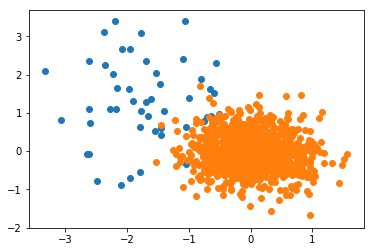

In [6]:
plt.scatter(anomaly_data[:,0], anomaly_data[:,1])
plt.scatter(regular_data[:,0], regular_data[:,1])
plt.show()

In [7]:
regular_pd = pd.DataFrame({'x': regular_data[:, 0], 'y': regular_data[:, 1], 'label': np.zeros(regular_data.shape[0])})
anomaly_pd = pd.DataFrame({'x': anomaly_data[:, 0], 'y': anomaly_data[:, 1], 'label': np.ones(anomaly_data.shape[0])})

In [8]:
dataset = H2OFrame(regular_pd.append(anomaly_pd).sample(frac=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
train_with_label, test = dataset.split_frame([0.8])

In [10]:
train_with_label["label"].table()

label,Count
0,761
1,40


In [11]:
test["label"].table()

label,Count
0,189
1,10


In [12]:
train = train_with_label.drop(["label"])
test["label"] = test["label"].asfactor()

In [13]:
from h2o.estimators.isolation_forest import H2OIsolationForestEstimator
from h2o.model.metrics_base import H2OAnomalyDetectionModelMetrics, H2OBinomialModelMetrics

### Train Isolation Forest with a validation set

In [14]:
if_model = H2OIsolationForestEstimator(seed=12, response_column="label", ntrees=200,
                                       score_tree_interval=7, stopping_rounds=3, stopping_metric="AUC")
if_model.train(training_frame=train, validation_frame=test)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [15]:
if_model

Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1593202267571_272


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,70.0,70.0,60646.0,8.0,8.0,8.0,26.0,107.0,64.35714




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.73278546954
Normalized Anomaly Score: 0.0636225072514

ModelMetricsBinomial: isolationforest
** Reported on validation data. **

MSE: 0.034764386047
RMSE: 0.186452101214
LogLoss: 0.13444714093
Mean Per-Class Error: 0.126455026455
AUC: 0.891534391534
AUCPR: 0.531854457721
Gini: 0.783068783069

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12925170068: 


,,0,1,Error,Rate
0,0,179.0,10.0,0.0529,(10.0/189.0)
1,1,2.0,8.0,0.2,(2.0/10.0)
2,Total,181.0,18.0,0.0603,(12.0/199.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.129252,0.571429,14.0
1,max f2,0.129252,0.689655,14.0
2,max f0point5,0.238095,0.576923,3.0
3,max accuracy,0.513605,0.959799,1.0
4,max precision,0.935374,1.000000,0.0
5,max recall,0.020408,1.000000,41.0
6,max specificity,0.935374,1.000000,0.0
7,max absolute_mcc,0.129252,0.569021,14.0
8,max min_per_class_accuracy,0.129252,0.800000,14.0
9,max mean_per_class_accuracy,0.129252,0.873545,14.0



Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-06-26 17:38:38,0.001 sec,0.0,NaN,NaN
1,,2020-06-26 17:38:38,0.020 sec,7.0,6.791716,0.044182
2,,2020-06-26 17:38:38,0.036 sec,14.0,6.769952,0.050323
3,,2020-06-26 17:38:38,0.053 sec,21.0,6.747324,0.056449
4,,2020-06-26 17:38:38,0.066 sec,28.0,6.737706,0.058288
5,,2020-06-26 17:38:38,0.079 sec,35.0,6.733153,0.061852
6,,2020-06-26 17:38:38,0.095 sec,42.0,6.730316,0.063278
7,,2020-06-26 17:38:38,0.109 sec,49.0,6.734563,0.062232
8,,2020-06-26 17:38:38,0.124 sec,56.0,6.739710,0.061764
9,,2020-06-26 17:38:38,0.139 sec,63.0,6.736726,0.061659


In [16]:
predicted_train_labels = if_model.predict(train)["predict"].as_data_frame(use_pandas=True)

isolationforest prediction progress: |████████████████████████████████████| 100%


In [17]:
train_pd = train.as_data_frame(use_pandas=True)

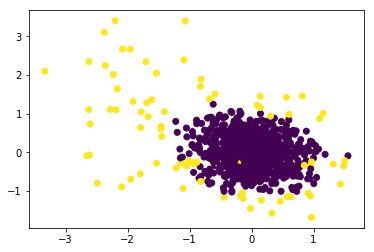

In [18]:
plt.scatter(train_pd["x"], train_pd["y"], c=predicted_train_labels["predict"])
plt.show()

In [19]:
if_model.model_performance(train_with_label)


ModelMetricsBinomial: isolationforest
** Reported on test data. **

MSE: 0.0273457867609
RMSE: 0.165365615413
LogLoss: 0.108682638841
Mean Per-Class Error: 0.0946944809461
AUC: 0.947273324573
AUCPR: 0.709912837678
Gini: 0.894546649146

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.210884353741: 


,,0,1,Error,Rate
0,0,746.0,15.0,0.0197,(15.0/761.0)
1,1,12.0,28.0,0.3,(12.0/40.0)
2,Total,758.0,43.0,0.0337,(27.0/801.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.210884,0.674699,35.0
1,max f2,0.149660,0.733333,49.0
2,max f0point5,0.408163,0.721154,15.0
3,max accuracy,0.408163,0.967541,15.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.013605,1.000000,89.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.210884,0.657426,35.0
8,max min_per_class_accuracy,0.129252,0.875000,55.0
9,max mean_per_class_accuracy,0.129252,0.905306,55.0


### Train Isolation Forest using contamination parameter

In [20]:
if_model_cont = H2OIsolationForestEstimator(seed=12, contamination=cont)
if_model_cont.train(training_frame=train)
if_model_cont

/Users/mkurka/git/h2o/h2o-3/h2o-py/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1593202267571_273


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,43788.0,8.0,8.0,8.0,33.0,107.0,65.1




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.73443250342
Normalized Anomaly Score: 0.0623397879303

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-06-26 17:38:39,0.003 sec,0.0,NaN,NaN
1,,2020-06-26 17:38:39,0.009 sec,1.0,6.876173,0.024765
2,,2020-06-26 17:38:39,0.017 sec,2.0,6.837857,0.027024
3,,2020-06-26 17:38:39,0.025 sec,3.0,6.789667,0.052583
4,,2020-06-26 17:38:39,0.032 sec,4.0,6.792303,0.046155
5,,2020-06-26 17:38:39,0.047 sec,5.0,6.784797,0.048910
6,,2020-06-26 17:38:39,0.052 sec,6.0,6.800709,0.044287
7,,2020-06-26 17:38:39,0.061 sec,7.0,6.791716,0.044182
8,,2020-06-26 17:38:39,0.066 sec,8.0,6.798208,0.041393
9,,2020-06-26 17:38:39,0.071 sec,9.0,6.788205,0.043322



See the whole table with table.as_data_frame()


In [21]:
predicted_train_labels_cont = if_model_cont.predict(train)["predict"].as_data_frame(use_pandas=True)

isolationforest prediction progress: |████████████████████████████████████| 100%


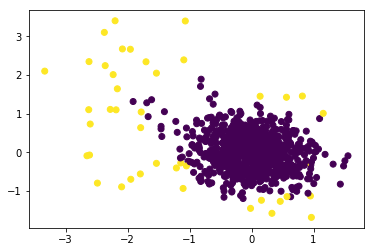

In [22]:
plt.scatter(train_pd["x"], train_pd["y"], c=predicted_train_labels_cont["predict"])
plt.show()